In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [7]:
import re
import nltk
import numpy as np

# nltk.download('punkt')
from nltk.tokenize import word_tokenize

corpus=open("data/data100652/corpus.txt").read() #文本数据集
# print(corpus)
corpus=corpus.lower()
clean_corpus=re.sub('[^a-z0-9]+',' ', corpus) #去除标点符号 空格

tokens = word_tokenize(clean_corpus)
print(tokens) ###分词

train_len = 3 #句子长度
text_sequences = []
for i in range(train_len,len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)
# print(text_sequences)

# #将文本转变为标号
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(text_sequences)
# sequences = tokenizer.texts_to_sequences(text_sequences)
# print(sequences)

#构造词典，统计每一个词的频率并根据词频转换为整数id
def build_dict(tokens):
    word_freq_dict = dict()
    for s in tokens:
        if s not in word_freq_dict:
            word_freq_dict[s]=0
        word_freq_dict[s]+=1
    word_freq_dict = sorted(word_freq_dict.items(),key=lambda x:x[1],reverse=True)
    word2id_dict=dict()
    word2id_freq=dict()
    for word,freq in word_freq_dict:
        word2id_dict[word] = len(word2id_dict)
        word2id_freq[word2id_dict[word]]=freq

    return word2id_freq,word2id_dict

def convert_to_id(text_sequences,word2id_dict):
    data_set = []
    for s in text_sequences:
        s =[word2id_dict[word] for word in s]
        data_set.append(s)
    return data_set


word2id_freq,word2id_dict = build_dict(tokens)
vocab_size = len(word2id_freq)
print(vocab_size)

train_set = convert_to_id(text_sequences,word2id_dict)
print(train_set)

['next', 'word', 'prediction', 'is', 'also', 'called', 'language', 'modeling', 'it', 'is', 'the', 'task', 'of', 'predicting', 'what', 'word', 'comes', 'next', 'it', 'is', 'one', 'of', 'the', 'fundamental', 'tasks', 'of', 'nlp', 'and', 'has', 'many', 'applications', 'you', 'might', 'be', 'using', 'it', 'daily', 'when', 'you', 'write', 'texts', 'or', 'emails', 'without', 'realizing', 'it', 'the', 'people', 's', 'republic', 'of', 'china', 'or', 'china', 'for', 'short', 'was', 'founded', 'on', 'october', '1', '1949', 'it', 'is', 'located', 'in', 'the', 'east', 'of', 'asia', 'and', 'the', 'west', 'coast', 'of', 'the', 'pacific', 'ocean', 'it', 'is', 'a', 'socialist', 'country', 'under', 'the', 'people', 's', 'democratic', 'dictatorship', 'led', 'by', 'the', 'working', 'class', 'and', 'based', 'on', 'the', 'alliance', 'of', 'workers', 'and', 'peasants']
69
[[5, 6, 13], [6, 13, 3], [13, 3, 14], [3, 14, 15], [14, 15, 16], [15, 16, 17], [16, 17, 2], [17, 2, 3], [2, 3, 0], [3, 0, 18], [0, 18, 1]

In [10]:
sequences=np.asarray(train_set)
train_inputs=sequences[:,:-1] #最终的训练输入

seq_length=train_inputs.shape[1]

train_label=sequences[:,-1]  #最终的训练标签

#将标签转换为独热编码
onehot_label = np.zeros([train_inputs.shape[0],vocab_size])
for i in range(train_inputs.shape[0]):
    onehot_label[i,train_label[i]]=1
print(type(onehot_label))

<class 'numpy.ndarray'>


In [59]:
#构建LSTM模型
import paddle
import paddle.nn.functional as F
import paddle.fluid as fluid
import numpy as np
from paddle.fluid.dygraph.nn import Embedding
import random
#参数设置
embedding_size = 128
hidden_size = 256
num_encoder_lstm_layers = 3
input_vocab_size = vocab_size
epochs = 200
batch_size = 7
class LSTM(paddle.nn.Layer):
    def __init__(self,input_vocab_size,embedding_size,hidden_size):
        super(LSTM, self).__init__()
        self.emb = paddle.nn.Embedding(input_vocab_size, embedding_size)
        self.lstm = paddle.nn.LSTM(input_size=embedding_size, 
                                   hidden_size=hidden_size, 
                                   num_layers=num_encoder_lstm_layers)
        self.linear = paddle.nn.Linear(in_features=2*hidden_size,out_features=input_vocab_size,weight_attr=None)
        
    def forward(self,input_word):
        input_word = paddle.to_tensor(input_word)
        embedded = self.emb(input_word)
        
        # embedded = paddle.reshape(embedded,shape=[-1,input_vocab_size, embedding_size])
        #passing the embedding to lstm model
        output, hidden = self.lstm(embedded)
        
        #reshaping
        logits=paddle.reshape(output,shape=[-1,2*hidden_size])
        # print(logits)
        #fully connected layer
        logits = self.linear(logits)
        return logits,hidden

#训练
#检测是否可以使用GPU，如果可以优先使用GPu
use_gpu= True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu：0')
model = LSTM(input_vocab_size,embedding_size,hidden_size)
optimizer = paddle.optimizer.Adam(learning_rate=0.01,beta1=0.9,beta2=0.999,parameters= model.parameters())
losses=[]
steps=[]
# seq_set = sequences
# for i in range(seq_set.shape[0]):
#     seq_set[i,-1]=i
def train(model,train_set,onehot_label,batch_size,epochs):
    model.train()
    onehot_label=paddle.to_tensor(onehot_label).astype('float32')
    batch_num = int(train_set.shape[0]/batch_size)
    #生成mini-batch
    # label_batch=onehot_label[0:batch_num]
    # def get_batch(batch_size,seq_set,train_label,i):
    #     if True:
    #         random.shuffle(seq_set)
        
    #     # for num in range(batch_num):
    #     seq_batch = seq_set[i*batch_num:(i+1)*batch_num,:-1]
    #     id_select = list(seq_set[i*batch_num:(i+1)*batch_num,-1])
    #     for i in range(len(id_select)):
    #         label_batch[i] = onehot_label[id_select[i]]
    #     return seq_batch,label_batch
    for e in range(epochs):
        # for i in range(batch_num):
        #     seq_batch,label_batch = get_batch(batch_size,seq_set,train_label,i)
        #     seq_batch = paddle.to_tensor(seq_batch)
        #     label_batch = paddle.to_tensor(label_batch)
        #     logits,_ = model(seq_batch)
        #     print(logits)
        #     loss = F.cross_entropy(input=logits,label=label_batch,soft_label=False)
        #     loss = paddle.mean(loss)

        #     #后向传播
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.clear_grad()
        logits,_=model(train_set)
        # print(logits)
        loss = F.binary_cross_entropy_with_logits(logit=logits,label=onehot_label)
        loss = paddle.mean(loss)
        #后向传播
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        losses.append(loss.numpy()[0])
        steps.append(e)
        print("epoch:%d,loss:%.3f"% (e,loss.numpy()[0]))

train(model,train_inputs,onehot_label,batch_size,epochs)
    


epoch:0,loss:0.693
epoch:1,loss:0.641
epoch:2,loss:0.539
epoch:3,loss:0.344
epoch:4,loss:0.121
epoch:5,loss:0.085
epoch:6,loss:0.120
epoch:7,loss:0.141
epoch:8,loss:0.149
epoch:9,loss:0.148
epoch:10,loss:0.141
epoch:11,loss:0.130
epoch:12,loss:0.121
epoch:13,loss:0.114
epoch:14,loss:0.107
epoch:15,loss:0.099
epoch:16,loss:0.091
epoch:17,loss:0.083
epoch:18,loss:0.078
epoch:19,loss:0.076
epoch:20,loss:0.076
epoch:21,loss:0.076
epoch:22,loss:0.076
epoch:23,loss:0.076
epoch:24,loss:0.075
epoch:25,loss:0.075
epoch:26,loss:0.074
epoch:27,loss:0.074
epoch:28,loss:0.075
epoch:29,loss:0.075
epoch:30,loss:0.075
epoch:31,loss:0.075
epoch:32,loss:0.075
epoch:33,loss:0.075
epoch:34,loss:0.074
epoch:35,loss:0.074
epoch:36,loss:0.073
epoch:37,loss:0.073
epoch:38,loss:0.072
epoch:39,loss:0.072
epoch:40,loss:0.072
epoch:41,loss:0.072
epoch:42,loss:0.072
epoch:43,loss:0.072
epoch:44,loss:0.072
epoch:45,loss:0.072
epoch:46,loss:0.071
epoch:47,loss:0.071
epoch:48,loss:0.071
epoch:49,loss:0.071
epoch:50,l

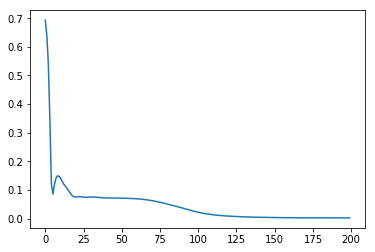

In [60]:
import matplotlib.pyplot as plt
plt.plot(steps,losses,label='Training loss')
plt.show()

In [61]:
import paddle
def predict_next_word(model,text,word2id_dict):
    model.eval()
    text = text.lower().strip()
    input_tokens = word_tokenize(text)
    word_list = []
    for w in input_tokens:
        word_list.append(word2id_dict[w])
    sequences=np.array(word_list)
    sequences=sequences.reshape([2,1])
    sequences=paddle.to_tensor(sequences)
 
    next_word,_ = model(sequences)
    softmax = paddle.exp(next_word)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob)
    next_word=[key for key, value in word2id_dict.items() if value == predictions]
    return next_word
#计算正确率 test_set 测试集 
def get_accuracy(model,test_set,test_label):
    model.eval()
    correct =0
    for i in range(test_set.shape[0]):
        input_seq = paddle.to_tensor(test_set[i,:])
        input_seq = paddle.reshape(input_seq,shape=[2,1])
        next_word,_ = model(input_seq)
        softmax = paddle.exp(next_word)
        prob = list(softmax.numpy())
        predictions = np.argmax(prob)
        if predictions==test_label[i]:
            correct +=1
    return float(correct/test_set.shape[0])
text ="next word"
next_word = predict_next_word(model,text,word2id_dict)
print("next word is:  {}".format(next_word[0]))

acc = get_accuracy(model,train_inputs,train_label)
print(acc)

next word is:  prediction
0.6831683168316832
